In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import os
import time

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"

import warnings
from functools import partial
from pathlib import Path

import humanize
from darts.metrics import mae, mase, mse
from sklearn.preprocessing import StandardScaler
from src.utils import plotting_utils
from src.utils.general import LogTime
from src.utils.ts_utils import darts_metrics_adapter, forecast_bias
from tqdm.autonotebook import tqdm
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
import random

random.seed(42)
tqdm.pandas()

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-\src\utils\data_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_8", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")

In [4]:
def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
    )
    return fig

# Reading the Test Predictions and Metrics

In [5]:
try:
    # Readin the missing value imputed and train test split data
    train_df = pd.read_parquet(
        preprocessed / "selected_blocks_train_missing_imputed_feature_engg.parquet"
    )
    train_df = train_df.loc[:, ["timestamp", "LCLid", "energy_consumption"]].set_index(
        ["timestamp", "LCLid"]
    )
    val_df = pd.read_parquet(
        preprocessed / "selected_blocks_val_missing_imputed_feature_engg.parquet"
    )
    val_df = val_df.loc[:, ["timestamp", "LCLid", "energy_consumption"]].set_index(
        ["timestamp", "LCLid"]
    )

    train_target = train_df.reset_index().set_index("timestamp")
    # Combine train and val into new train
    train_val_target = pd.concat([train_df, val_df]).reset_index().set_index("timestamp")

    del val_df, train_df
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

In [6]:
try:
    pred_test_df = pd.read_pickle(output / "ml_single_step_prediction_test_df.pkl")
    metrics_test_df = pd.read_pickle(output / "ml_single_step_metrics_test_df.pkl")
    pred_auto_stat_test_df = pd.read_pickle(
        output / "ml_single_step_prediction_auto_stationary_test_df.pkl"
    )
    metrics_auto_stat_test_df = pd.read_pickle(
        output / "ml_single_step_metrics_auto_stationary_test_df.pkl"
    )
    agg_metrics_auto_stat_test_df = pd.read_pickle(
        output / "ml_single_step_aggregate_metrics_auto_stationary_test.pkl"
    )
    pred_baselines_test_df = pd.read_pickle(output / "baseline_test_prediction_df.pkl")
    metrics_baselines_test_df = pd.read_pickle(output / "baseline_test_metrics_df.pkl")
    agg_metrics_baselines_test_df = pd.read_pickle(
        output / "baseline_test_aggregate_metrics.pkl"
    )


    pred_val_df = pd.read_pickle(output / "ml_single_step_prediction_val_df.pkl")
    metrics_val_df = pd.read_pickle(output / "ml_single_step_metrics_val_df.pkl")
    pred_auto_stat_val_df = pd.read_pickle(
        output / "ml_single_step_prediction_auto_stationary_val_df.pkl"
    )
    metrics_auto_stat_val_df = pd.read_pickle(
        output / "ml_single_step_metrics_auto_stationary_val_df.pkl"
    )
    agg_metrics_auto_stat_val_df = pd.read_pickle(
        output / "ml_single_step_aggregate_metrics_auto_stationary_val.pkl"
    )
    pred_baselines_val_df = pd.read_pickle(output / "baseline_val_prediction_df.pkl")
    metrics_baselines_val_df = pd.read_pickle(output / "baseline_val_metrics_df.pkl")
    agg_metrics_baselines_val_df = pd.read_pickle(
        output / "baseline_val_aggregate_metrics.pkl"
    )
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run all notebooks in Chapter08 and 02-Baseline Forecasts using darts.ipynb in Chapter04
    </div>
    """))

In [7]:
pred_val_df = pd.concat([pred_val_df, pred_auto_stat_val_df, pred_baselines_val_df])
pred_val_df.index.name = "timestamp"

pred_wide_val = pd.pivot(
    pred_val_df.reset_index(),
    index=["LCLid", "timestamp"],
    columns="Algorithm",
    values="predictions",
)
pred_wide_val = pred_wide_val.join(
    pred_val_df.loc[
        pred_val_df.Algorithm == "Lasso Regression", ["LCLid", "energy_consumption"]
    ]
    .reset_index()
    .set_index(["LCLid", "timestamp"])
)
pred_wide_val.head()

FFT  Lasso Regression  \
LCLid     timestamp                                         
MAC000061 2014-01-01 00:00:00  0.111663          0.131019   
          2014-01-01 00:30:00  0.088207          0.114567   
          2014-01-01 01:00:00  0.070980          0.121938   
          2014-01-01 01:30:00  0.060706          0.112447   
          2014-01-01 02:00:00  0.056753          0.073498   

                               Lasso Regression_auto_stat  LightGBM  \
LCLid     timestamp                                                   
MAC000061 2014-01-01 00:00:00                    0.119527  0.116644   
          2014-01-01 00:30:00                    0.105032  0.093251   
          2014-01-01 01:00:00                    0.129581  0.095208   
          2014-01-01 01:30:00                    0.120940  0.077936   
          2014-01-01 02:00:00                    0.080311  0.063477   

                               LightGBM_auto_stat     Theta  \
LCLid     timestamp                                           
MAC000061 2014-01-01 00:00:00            0.088220  0.157925   
          2014-01-01 00:30:00            0.077768  0.150391   
          2014-01-01 01:00:00            0.075597  0.147510   
          2014-01-01 01:30:00            0.070967  0.146589   
          2014-01-01 02:00:00            0.055991  0.147600   

                               XGB Random Forest  XGB Random Forest_auto_stat  \
LCLid     timestamp                                                             
MAC000061 2014-01-01 00:00:00           0.117223                     0.091740   
          2014-01-01 00:30:00           0.107443                     0.068490   
          2014-01-01 01:00:00           0.107443                     0.069829   
          2014-01-01 01:30:00           0.105046                     0.054205   
          2014-01-01 02:00:00           0.072566                     0.048821   

                               energy_consumption  
LCLid     timestamp                                
MAC000061 2014-01-01 00:00:00               0.165  
          2014-01-01 00:30:00               0.167  
          2014-01-01 01:00:00               0.150  
          2014-01-01 01:30:00               0.091  
          2014-01-01 02:00:00               0.047

In [8]:
pred_test_df = pd.concat([pred_test_df, pred_auto_stat_test_df, pred_baselines_test_df])
pred_test_df.index.name = "timestamp"

pred_wide_test = pd.pivot(
    pred_test_df.reset_index(),
    index=["LCLid", "timestamp"],
    columns="Algorithm",
    values="predictions",
)
pred_wide_test = pred_wide_test.join(
    pred_test_df.loc[
        pred_test_df.Algorithm == "Lasso Regression", ["LCLid", "energy_consumption"]
    ]
    .reset_index()
    .set_index(["LCLid", "timestamp"])
)
pred_wide_test.head()

FFT  Lasso Regression  \
LCLid     timestamp                                         
MAC000061 2014-02-01 00:00:00  0.113955          0.057970   
          2014-02-01 00:30:00  0.087921          0.052872   
          2014-02-01 01:00:00  0.068605          0.055564   
          2014-02-01 01:30:00  0.056841          0.038991   
          2014-02-01 02:00:00  0.051993          0.026235   

                               Lasso Regression_auto_stat  LightGBM  \
LCLid     timestamp                                                   
MAC000061 2014-02-01 00:00:00                    0.069638  0.066419   
          2014-02-01 00:30:00                    0.056015  0.059460   
          2014-02-01 01:00:00                    0.065261  0.056335   
          2014-02-01 01:30:00                    0.045631  0.024908   
          2014-02-01 02:00:00                    0.030801  0.022665   

                               LightGBM_auto_stat     Theta  \
LCLid     timestamp                                           
MAC000061 2014-02-01 00:00:00            0.077820  0.020412   
          2014-02-01 00:30:00            0.057761  0.002474   
          2014-02-01 01:00:00            0.057977 -0.007651   
          2014-02-01 01:30:00            0.027831 -0.009468   
          2014-02-01 02:00:00            0.018281 -0.011249   

                               XGB Random Forest  XGB Random Forest_auto_stat  \
LCLid     timestamp                                                             
MAC000061 2014-02-01 00:00:00           0.079946                     0.065736   
          2014-02-01 00:30:00           0.062657                     0.061469   
          2014-02-01 01:00:00           0.052433                     0.051756   
          2014-02-01 01:30:00           0.045367                     0.032001   
          2014-02-01 02:00:00           0.032464                     0.026998   

                               energy_consumption  
LCLid     timestamp                                
MAC000061 2014-02-01 00:00:00               0.066  
          2014-02-01 00:30:00               0.063  
          2014-02-01 01:00:00               0.040  
          2014-02-01 01:30:00               0.020  
          2014-02-01 02:00:00               0.018

In [9]:
metrics_combined_df = pd.concat([metrics_val_df, metrics_auto_stat_val_df])
metrics_combined_df = pd.pivot(
    metrics_combined_df, index="LCLid", columns="Algorithm", values="MAE"
)
metrics_combined_df.head()

Algorithm  Lasso Regression  Lasso Regression_auto_stat  LightGBM  \
LCLid                                                               
MAC000061          0.033292                    0.036641  0.030848   
MAC000062          0.069219                    0.068970  0.076393   
MAC000066          0.041440                    0.042816  0.039015   
MAC000086          0.126438                    0.122261  0.103096   
MAC000126          0.065665                    0.064993  0.065207   

Algorithm  LightGBM_auto_stat  XGB Random Forest  XGB Random Forest_auto_stat  
LCLid                                                                          
MAC000061            0.032639           0.031657                     0.035673  
MAC000062            0.069722           0.069521                     0.071601  
MAC000066            0.040707           0.038356                     0.042510  
MAC000086            0.105943           0.114561                     0.115065  
MAC000126            0.063308           0.065174                     0.063456

# Combining Forecasts

In [10]:
from src.forecasting.ml_forecasting import calculate_metrics
from src.utils import ts_utils

In [11]:
def evaluate_ensemble(pred_wide, target_history, model, target, unique_id):
    metric_l = []
    for _id in tqdm(pred_wide.reset_index()[unique_id].unique()):
        # unique_mask = pred_wide[unique_id]==_id
        wide_df = pred_wide.xs(_id)
        test_target = wide_df.loc[:, target]
        y_pred = wide_df.loc[:, model]
        history = target_history.loc[target_history[unique_id] == _id, target]
        metric_l.append(
            calculate_metrics(test_target, y_pred, name=model, y_train=history)
        )
    eval_metrics_df = pd.DataFrame(metric_l)
    return {
        "Algorithm": model,
        "MAE": ts_utils.mae(
            pred_wide.loc[:, "energy_consumption"], pred_wide.loc[:, model]
        ),
        "MSE": ts_utils.mse(
            pred_wide.loc[:, "energy_consumption"], pred_wide.loc[:, model]
        ),
        "meanMASE": eval_metrics_df.loc[:, "MASE"].mean(),
        "Forecast Bias": ts_utils.forecast_bias_aggregate(
            pred_wide.loc[:, "energy_consumption"], pred_wide.loc[:, model]
        ),
    }


def highlight_abs_min(s, props=""):
    return np.where(s == np.nanmin(np.abs(s.values)), props, "")

In [12]:
def display_metrics(agg_metrics_l):
    _agg_metrics_df = pd.DataFrame(agg_metrics_l)
    display(
        _agg_metrics_df.style.format(
            {
                "MAE": "{:.4f}",
                "MSE": "{:.4f}",
                "meanMASE": "{:.4f}",
                "Forecast Bias": "{:.2f}%",
            }
        )
        .highlight_min(color="lightgreen", subset=["MAE", "MSE", "meanMASE"])
        .apply(
            highlight_abs_min,
            props="color:black;background-color:lightgreen",
            axis=0,
            subset=["Forecast Bias"],
        )
    )

In [13]:
ensemble_forecasts = [
    "FFT",
    "Lasso Regression",
    "Lasso Regression_auto_stat",
    "LightGBM",
    "LightGBM_auto_stat",
    "Theta",
    "XGB Random Forest",
    "XGB Random Forest_auto_stat",
]

In [14]:
# Picking LightGBM which is the best single model as the baseline
agg_metrics_l = agg_metrics_auto_stat_test_df.iloc[[4]].to_dict(orient="records")

## "Best-Fit"

In [15]:
# Finding the lowest metric for each LCLid
best_alg = metrics_combined_df.idxmin(axis=1)
best_alg.head()

LCLid
MAC000061                      LightGBM
MAC000062    Lasso Regression_auto_stat
MAC000066             XGB Random Forest
MAC000086                      LightGBM
MAC000126            LightGBM_auto_stat
dtype: object

In [16]:
# Initialize two columns in the dataframe
pred_wide_test["best_fit"] = np.nan
pred_wide_test["best_fit_alg"] = ""
# For each LCL id
for lcl_id in tqdm(pred_wide_test.index.get_level_values(0).unique()):
    # pick the best algorithm
    alg = best_alg[lcl_id]
    # and store the forecast in the best_fit column
    pred_wide_test.loc[lcl_id, "best_fit"] = pred_wide_test.loc[lcl_id, alg].values
    # also store which model was chosen for traceability
    pred_wide_test.loc[lcl_id, "best_fit_alg"] = alg

  0%|          | 0/150 [00:00<?, ?it/s]

In [17]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test, train_val_target, "best_fit", "energy_consumption", "LCLid"
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'best_fit', 'MAE': 0.07404407846371805, 'MSE': 0.026864705145805353, 'meanMASE': 0.8971306927020752, 'Forecast Bias': 0.1428475982259044}


In [18]:
display_metrics(agg_metrics_l)

## Average and Median Ensemble

In [19]:
# ensemble_forecasts is a list of column names(forecast) we want to combine
pred_wide_test["average_ensemble"] = pred_wide_test[ensemble_forecasts].mean(axis=1)
pred_wide_test["median_ensemble"] = pred_wide_test[ensemble_forecasts].median(axis=1)

In [20]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test, train_val_target, "median_ensemble", "energy_consumption", "LCLid"
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)
agg_metric_ = evaluate_ensemble(
    pred_wide_test, train_val_target, "average_ensemble", "energy_consumption", "LCLid"
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'median_ensemble', 'MAE': 0.07669767491550654, 'MSE': 0.027941810233074814, 'meanMASE': 0.9304386219956844, 'Forecast Bias': -0.8616476575178732}


  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'average_ensemble', 'MAE': 0.08276100517283759, 'MSE': 0.028497147168131547, 'meanMASE': 1.015856105472311, 'Forecast Bias': 1.5819291520684533}


In [21]:
display_metrics(agg_metrics_l)

## Greedy Optimization

In [22]:
from src.forecasting.ensembling import calculate_performance, greedy_optimization

In [23]:
objective = partial(
    calculate_performance, pred_wide=pred_wide_val, target="energy_consumption"
)

In [24]:
solution, best_score = greedy_optimization(objective, ensemble_forecasts)

Solution: ['LightGBM', 'LightGBM_auto_stat'] | Best Score: 0.07592195649145433
Solution: ['LightGBM', 'LightGBM_auto_stat', 'Lasso Regression'] | Best Score: 0.0755820371068078
Solution cannot be improved further. Stopping optimization.


In [25]:
pred_wide_test["greedy_ensemble"] = pred_wide_test[solution].mean(axis=1)

In [26]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test, train_val_target, "greedy_ensemble", "energy_consumption", "LCLid"
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'greedy_ensemble', 'MAE': 0.07333856383624388, 'MSE': 0.025062587695497632, 'meanMASE': 0.8951353934984048, 'Forecast Bias': 0.812712631786243}


In [27]:
display_metrics(agg_metrics_l)

## Stochastic Hill-climbing with Validation Forecasts

In [28]:
from src.forecasting.ensembling import stochastic_hillclimbing

In [29]:
objective = partial(
    calculate_performance, pred_wide=pred_wide_val, target="energy_consumption"
)

In [30]:
solution, best_score = stochastic_hillclimbing(
    objective, ensemble_forecasts, n_iterations=10, init="best", random_state=42
)

Iteration: 0: Iteration did not improve the score. Solution: ['LightGBM'] | Best Score: 0.0771825694448262
Iteration: 1: Iteration did not improve the score. Solution: ['LightGBM'] | Best Score: 0.0771825694448262
Iteration: 2: Iteration did not improve the score. Solution: ['LightGBM'] | Best Score: 0.0771825694448262
Iteration: 3: Iteration did not improve the score. Solution: ['LightGBM'] | Best Score: 0.0771825694448262
Iteration: 4: Solution: ['LightGBM', 'Lasso Regression_auto_stat'] | Best Score: 0.07646507730975023
Iteration: 5: Iteration did not improve the score. Solution: ['LightGBM', 'Lasso Regression_auto_stat'] | Best Score: 0.07646507730975023
Iteration: 6: Iteration did not improve the score. Solution: ['LightGBM', 'Lasso Regression_auto_stat'] | Best Score: 0.07646507730975023
Iteration: 7: Iteration did not improve the score. Solution: ['LightGBM', 'Lasso Regression_auto_stat'] | Best Score: 0.07646507730975023
Iteration: 8: Iteration did not improve the score. Soluti

In [31]:
pred_wide_test["stochastic_hillclimb__ensemble"] = pred_wide_test[solution].mean(axis=1)

In [32]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test,
    train_val_target,
    "stochastic_hillclimb__ensemble",
    "energy_consumption",
    "LCLid",
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'stochastic_hillclimb__ensemble', 'MAE': 0.07514784709741047, 'MSE': 0.025748472282634303, 'meanMASE': 0.9206141361113083, 'Forecast Bias': 1.184132870479175}


In [33]:
display_metrics(agg_metrics_l)

## Simulated Annealing with Validation Forecasts

In [34]:
from src.forecasting.ensembling import simulated_annealing

In [35]:
objective = partial(
    calculate_performance, pred_wide=pred_wide_val, target="energy_consumption"
)

In [36]:
solution, best_score = simulated_annealing(
    objective,
    ensemble_forecasts,
    p_range=(0.5, 0.0001),
    n_iterations=50,
    init="best",
    temperature_decay="geometric",
    random_state=42,
)

Finding optimum temperature range


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 0: Solution: ['LightGBM', 'LightGBM_auto_stat'] | Best Score: 0.07592195649145433
Iteration: 1: Iteration did not improve the score. Solution: ['LightGBM', 'LightGBM_auto_stat'] | Best Score: 0.07592195649145433
Iteration: 2: Solution: ['LightGBM', 'LightGBM_auto_stat', 'XGB Random Forest'] | Best Score: 0.075959599465929
Iteration: 3: Iteration did not improve the score. Solution: ['LightGBM', 'LightGBM_auto_stat', 'XGB Random Forest'] | Best Score: 0.075959599465929
Iteration: 4: Iteration did not improve the score. Solution: ['LightGBM', 'LightGBM_auto_stat', 'XGB Random Forest'] | Best Score: 0.075959599465929
Iteration: 5: Iteration did not improve the score. Solution: ['LightGBM', 'LightGBM_auto_stat', 'XGB Random Forest'] | Best Score: 0.075959599465929
Iteration: 6: Iteration did not improve the score. Solution: ['LightGBM', 'LightGBM_auto_stat', 'XGB Random Forest'] | Best Score: 0.075959599465929
Iteration: 7: Solution: ['LightGBM', 'LightGBM_auto_stat', 'XGB Rando

In [37]:
pred_wide_test["simulated_annealing_ensemble"] = pred_wide_test[solution].mean(axis=1)

In [38]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test,
    train_val_target,
    "simulated_annealing_ensemble",
    "energy_consumption",
    "LCLid",
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'simulated_annealing_ensemble', 'MAE': 0.07346605933328755, 'MSE': 0.024807495646711707, 'meanMASE': 0.9040785893664048, 'Forecast Bias': 0.2646047765236876}


In [39]:
display_metrics(agg_metrics_l)

## Optimal Weighted Ensemble

In [40]:
from src.forecasting.ensembling import find_optimal_combination

In [41]:
optimal_weights = find_optimal_combination(
    ensemble_forecasts, pred_wide_val, target="energy_consumption"
)

In [42]:
pd.DataFrame({"Forecast": ensemble_forecasts, "Weights": optimal_weights}).round(
    4
).sort_values("Weights", ascending=False)

Forecast  Weights
3                     LightGBM   0.4221
4           LightGBM_auto_stat   0.2991
2   Lasso Regression_auto_stat   0.1266
1             Lasso Regression   0.1012
6            XGB Random Forest   0.0510
0                          FFT   0.0000
5                        Theta   0.0000
7  XGB Random Forest_auto_stat   0.0000

In [43]:
pred_wide_test["optimal_combination_ensemble"] = np.sum(
    pred_wide_test[ensemble_forecasts].values * np.array(optimal_weights), axis=1
)

In [44]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test,
    train_val_target,
    "optimal_combination_ensemble",
    "energy_consumption",
    "LCLid",
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'optimal_combination_ensemble', 'MAE': 0.07315432429394163, 'MSE': 0.02482074152566708, 'meanMASE': 0.8956065268502925, 'Forecast Bias': 0.8139853183688807}


In [45]:
display_metrics(agg_metrics_l)

## Stacking/Blending Model

In [46]:
from sklearn.linear_model import (
    HuberRegressor,
    LassoCV,
    LinearRegression,
    RidgeCV
)

### Linear Regression

In [47]:
stacking_model = LinearRegression(positive=True, fit_intercept=False)
stacking_model.fit(
    pred_wide_val[ensemble_forecasts], pred_wide_val["energy_consumption"]
)

LinearRegression(fit_intercept=False, positive=True)

In [48]:
pd.DataFrame({"Forecast": ensemble_forecasts, "Weights": stacking_model.coef_}).round(
    4
).sort_values("Weights", ascending=False)

Forecast  Weights
3                     LightGBM   0.3977
2   Lasso Regression_auto_stat   0.2644
1             Lasso Regression   0.2264
4           LightGBM_auto_stat   0.1447
0                          FFT   0.0000
5                        Theta   0.0000
6            XGB Random Forest   0.0000
7  XGB Random Forest_auto_stat   0.0000

In [49]:
pred_wide_test["linear_reg_blending"] = stacking_model.predict(
    pred_wide_test[ensemble_forecasts]
)

In [50]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test,
    train_val_target,
    "linear_reg_blending",
    "energy_consumption",
    "LCLid",
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'linear_reg_blending', 'MAE': 0.07552320532606391, 'MSE': 0.024510828453323044, 'meanMASE': 0.9260299934831251, 'Forecast Bias': 4.3480011996089845}


In [51]:
display_metrics(agg_metrics_l)

### Ridge Regression

In [52]:
stacking_model = RidgeCV()
stacking_model.fit(
    pred_wide_val[ensemble_forecasts], pred_wide_val["energy_consumption"]
)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [53]:
pd.DataFrame({"Forecast": ensemble_forecasts, "Weights": stacking_model.coef_}).round(
    4
).sort_values("Weights", ascending=False)

Forecast  Weights
3                     LightGBM   0.4496
1             Lasso Regression   0.3439
4           LightGBM_auto_stat   0.2836
2   Lasso Regression_auto_stat   0.2274
0                          FFT  -0.0236
5                        Theta  -0.0262
7  XGB Random Forest_auto_stat  -0.0858
6            XGB Random Forest  -0.1566

In [54]:
pred_wide_test["ridge_reg_blending"] = stacking_model.predict(
    pred_wide_test[ensemble_forecasts]
)

In [55]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test,
    train_val_target,
    "ridge_reg_blending",
    "energy_consumption",
    "LCLid",
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'ridge_reg_blending', 'MAE': 0.07367415568334458, 'MSE': 0.02433397612022071, 'meanMASE': 0.9081723184247119, 'Forecast Bias': 1.8370649089237512}


In [56]:
display_metrics(agg_metrics_l)

In [57]:
# ts_utils.mae(pred_wide_val['energy_consumption'], stacking_model.predict(pred_wide_val[ensemble_forecasts]))

# ts_utils.mae(pred_wide_test['energy_consumption'], stacking_model.predict(pred_wide_test[ensemble_forecasts]))

### Lasso Regression

In [58]:
stacking_model = LassoCV()
stacking_model.fit(
    pred_wide_val[ensemble_forecasts], pred_wide_val["energy_consumption"]
)

LassoCV()

In [59]:
pd.DataFrame({"Forecast": ensemble_forecasts, "Weights": stacking_model.coef_}).round(
    4
).sort_values("Weights", ascending=False)

Forecast  Weights
3                     LightGBM   0.4306
1             Lasso Regression   0.3122
4           LightGBM_auto_stat   0.2482
2   Lasso Regression_auto_stat   0.2373
0                          FFT  -0.0196
5                        Theta  -0.0249
7  XGB Random Forest_auto_stat  -0.0612
6            XGB Random Forest  -0.1054

In [60]:
pred_wide_test["lasso_reg_blending"] = stacking_model.predict(
    pred_wide_test[ensemble_forecasts]
)

In [61]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test,
    train_val_target,
    "lasso_reg_blending",
    "energy_consumption",
    "LCLid",
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'lasso_reg_blending', 'MAE': 0.07362477309132415, 'MSE': 0.024320034658321308, 'meanMASE': 0.9068263513212322, 'Forecast Bias': 1.9422617452372721}


In [62]:
display_metrics(agg_metrics_l)

### Huber Regression

To optimize MAE, we can also use Huber Regressor which uses Huber Loss

In [63]:
stacking_model = HuberRegressor()
stacking_model.fit(
    pred_wide_val[ensemble_forecasts], pred_wide_val["energy_consumption"]
)

HuberRegressor()

In [64]:
pd.DataFrame({"Forecast": ensemble_forecasts, "Weights": stacking_model.coef_}).round(
    4
).sort_values("Weights", ascending=False)

Forecast  Weights
3                     LightGBM   0.3790
4           LightGBM_auto_stat   0.2992
1             Lasso Regression   0.1932
2   Lasso Regression_auto_stat   0.1467
6            XGB Random Forest   0.1090
5                        Theta  -0.0180
0                          FFT  -0.0542
7  XGB Random Forest_auto_stat  -0.0976

In [65]:
pred_wide_test["huber_reg_blending"] = stacking_model.predict(
    pred_wide_test[ensemble_forecasts]
)

In [66]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test,
    train_val_target,
    "huber_reg_blending",
    "energy_consumption",
    "LCLid",
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'huber_reg_blending', 'MAE': 0.07042085386545935, 'MSE': 0.02464895885731081, 'meanMASE': 0.8989280932204864, 'Forecast Bias': -6.416475913563696}


In [67]:
display_metrics(agg_metrics_l)

## Bonus: Regularization through Variety

### Correlation as Variety

In [68]:
from src.utils.plotting_utils import plot_correlation_plot

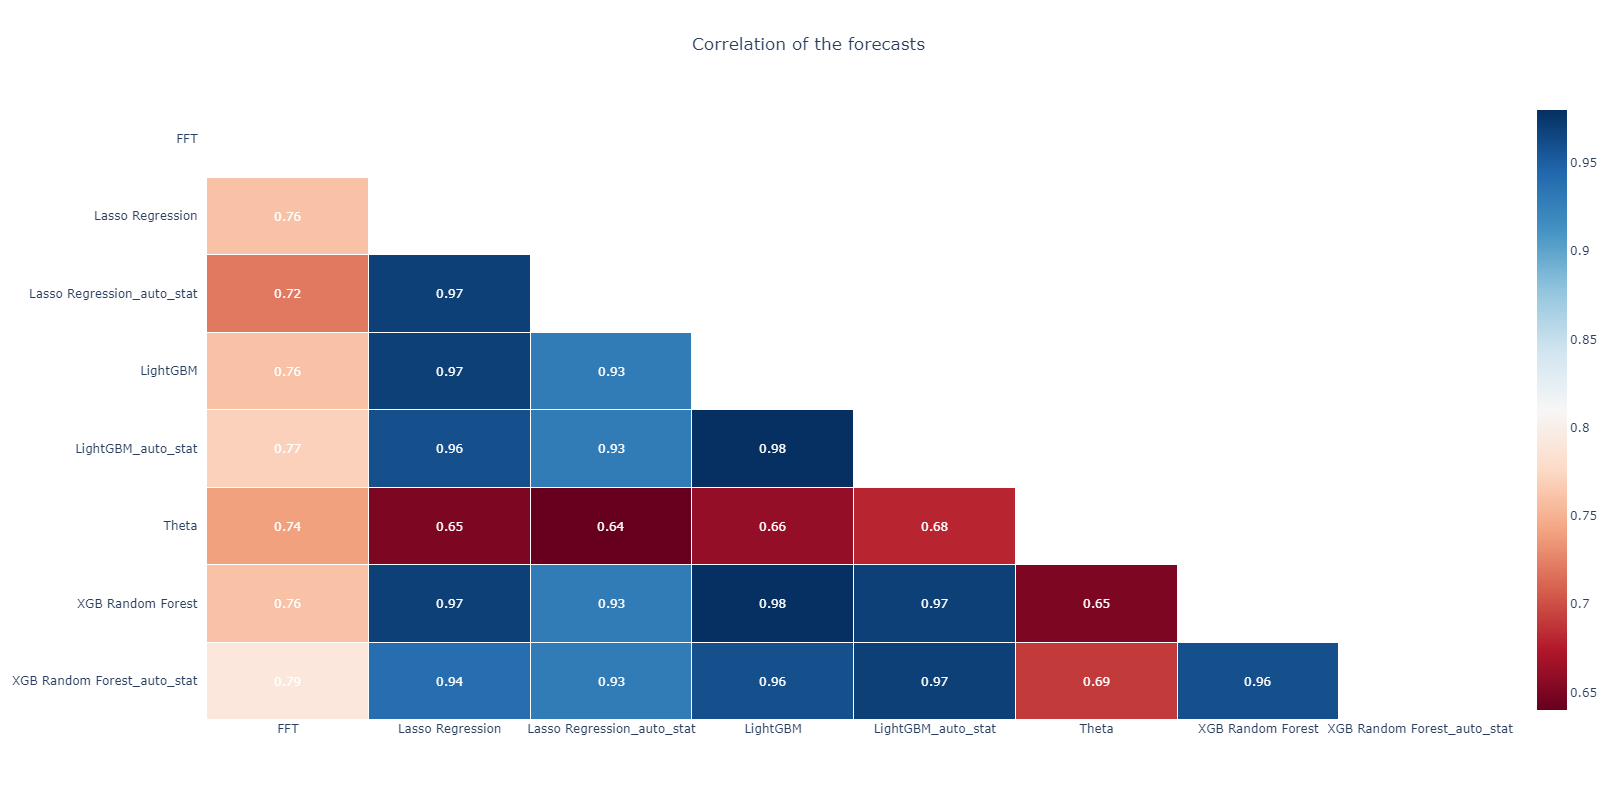

In [69]:
fig = plot_correlation_plot(
    pred_wide_val[ensemble_forecasts].corr(),
    title="Correlation of the forecasts",
    figsize=(800, 800),
)
fig.write_image("imgs/chapter_8/correlation.png")
fig.show()

### Using Variety as Regularization

In [70]:
from src.forecasting.ensembling import calculate_diversity

In [71]:
def calculate_diverse_objective(ens, pred_wide, target, diversity_matrix, alpha):
    perf = calculate_performance(ens, pred_wide, target)
    div = calculate_diversity(ens, diversity_matrix)
    return perf + alpha * div

In [72]:
objective = partial(
    calculate_diverse_objective,
    pred_wide=pred_wide_val,
    target="energy_consumption",
    diversity_matrix=pred_wide_val[ensemble_forecasts].corr(),
    alpha=0.05,
)

In [73]:
solution, best_score = stochastic_hillclimbing(
    objective, ensemble_forecasts, n_iterations=10, random_state=42
)

Iteration: 0: Solution: ['LightGBM', 'XGB Random Forest'] | Best Score: 0.1264608729501635
Iteration: 1: Iteration did not improve the score. Solution: ['LightGBM', 'XGB Random Forest'] | Best Score: 0.1264608729501635
Iteration: 2: Iteration did not improve the score. Solution: ['LightGBM', 'XGB Random Forest'] | Best Score: 0.1264608729501635
Iteration: 3: Solution: ['LightGBM', 'XGB Random Forest', 'XGB Random Forest_auto_stat'] | Best Score: 0.12569417930929142
Iteration: 4: Solution: ['LightGBM', 'XGB Random Forest', 'XGB Random Forest_auto_stat', 'Lasso Regression_auto_stat'] | Best Score: 0.12413993814964445
Iteration: 5: Iteration did not improve the score. Solution: ['LightGBM', 'XGB Random Forest', 'XGB Random Forest_auto_stat', 'Lasso Regression_auto_stat'] | Best Score: 0.12413993814964445
Iteration: 6: Iteration did not improve the score. Solution: ['LightGBM', 'XGB Random Forest', 'XGB Random Forest_auto_stat', 'Lasso Regression_auto_stat'] | Best Score: 0.124139938149644

In [74]:
# ts_utils.mae(pred_wide_test['energy_consumption'], pred_wide_test[solution].mean(axis=1).values)

In [75]:
pred_wide_test["hillclimbing_w_reg_ensemble"] = pred_wide_test[solution].mean(axis=1)

In [76]:
agg_metric_ = evaluate_ensemble(
    pred_wide_test,
    train_val_target,
    "hillclimbing_w_reg_ensemble",
    "energy_consumption",
    "LCLid",
)
print(agg_metric_)
agg_metrics_l.append(agg_metric_)

  0%|          | 0/150 [00:00<?, ?it/s]

{'Algorithm': 'hillclimbing_w_reg_ensemble', 'MAE': 0.07497538153534059, 'MSE': 0.02577367072111972, 'meanMASE': 0.9225153627139608, 'Forecast Bias': -0.42517967992088773}


In [77]:
display_metrics(agg_metrics_l)